In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# plotly
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# models
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
print('train:', train.shape, 'test:', test.shape, 'sample_submission:', sample_submission.shape)

train: (6079, 41) test: (476, 11) sample_submission: (476, 31)


In [4]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,...,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,...,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,...,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [5]:
sample_submission.columns

Index(['qa_id', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

30 target labels consist of 21 question related labels and 9 answer related labels.
NOTE: the labels are given in the continuous range from [0, 1]. NOT binary value.

    This is not a binary prediction challenge. Target labels are aggregated from multiple raters, and can have continuous values in the range [0,1]. Therefore, predictions must also be in that range.

In [6]:
feature_columns = [col for col in train.columns if col not in sample_submission.columns]
print(feature_columns)

['question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host']


In [7]:
train[feature_columns].head(1)

,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com


In [8]:
train0 = train.iloc[0]
print('URL', train0['url'])
print('question_title', train0['question_title'])
print('question_body', train0['question_body'])

URL http://photo.stackexchange.com/questions/9169/what-am-i-losing-when-using-extension-tubes-instead-of-a-macro-lens
question_title What am I losing when using extension tubes instead of a macro lens?
question_body After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help.

So, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens. An alternative is the electrical extension tubes.

Except for maximum focusing distance, what am I losing when using tubes (coupled with a fi

In [9]:
print('answer', train0['answer'])

answer I just got extension tubes, so here's the skinny.


  ...what am I losing when using tubes...?


A very considerable amount of light!  Increasing that distance from the end of the lens to the sensor can cut your light several stops.  Combined with the fact that you'll usually shoot stopped down - expect to need to increase your ISO considerably.

The fact the macro's are usually considered very very sharp, although I believe that 70-200mm 2.8 is supposed to be quite sharp.

The ultra low distortion typical of many macros.

I wouldn't worry too much about the bokeh since the DOF will still be quite limited.

Coupled on my 50mm, a full 60mm'ish extension tube results in a DOF of about a couple inches in front of the lens.  On my 70-300, its probably around 2-3 feet in front of the lens to about a foot in front of the lens.



When you access to the URL, you can understand that multiple answer to the single question is given in the page. But only one answer is sampled in the dataset. Also this answer may not be the most popular answer. We can find the answer of this data in the relatively bottom part of the homepage.

Other columns are metadata, which shows question user property, answer user property and category of question.

In [10]:
target_cols = sample_submission.columns.to_list()

In [11]:
target_cols.remove('qa_id')

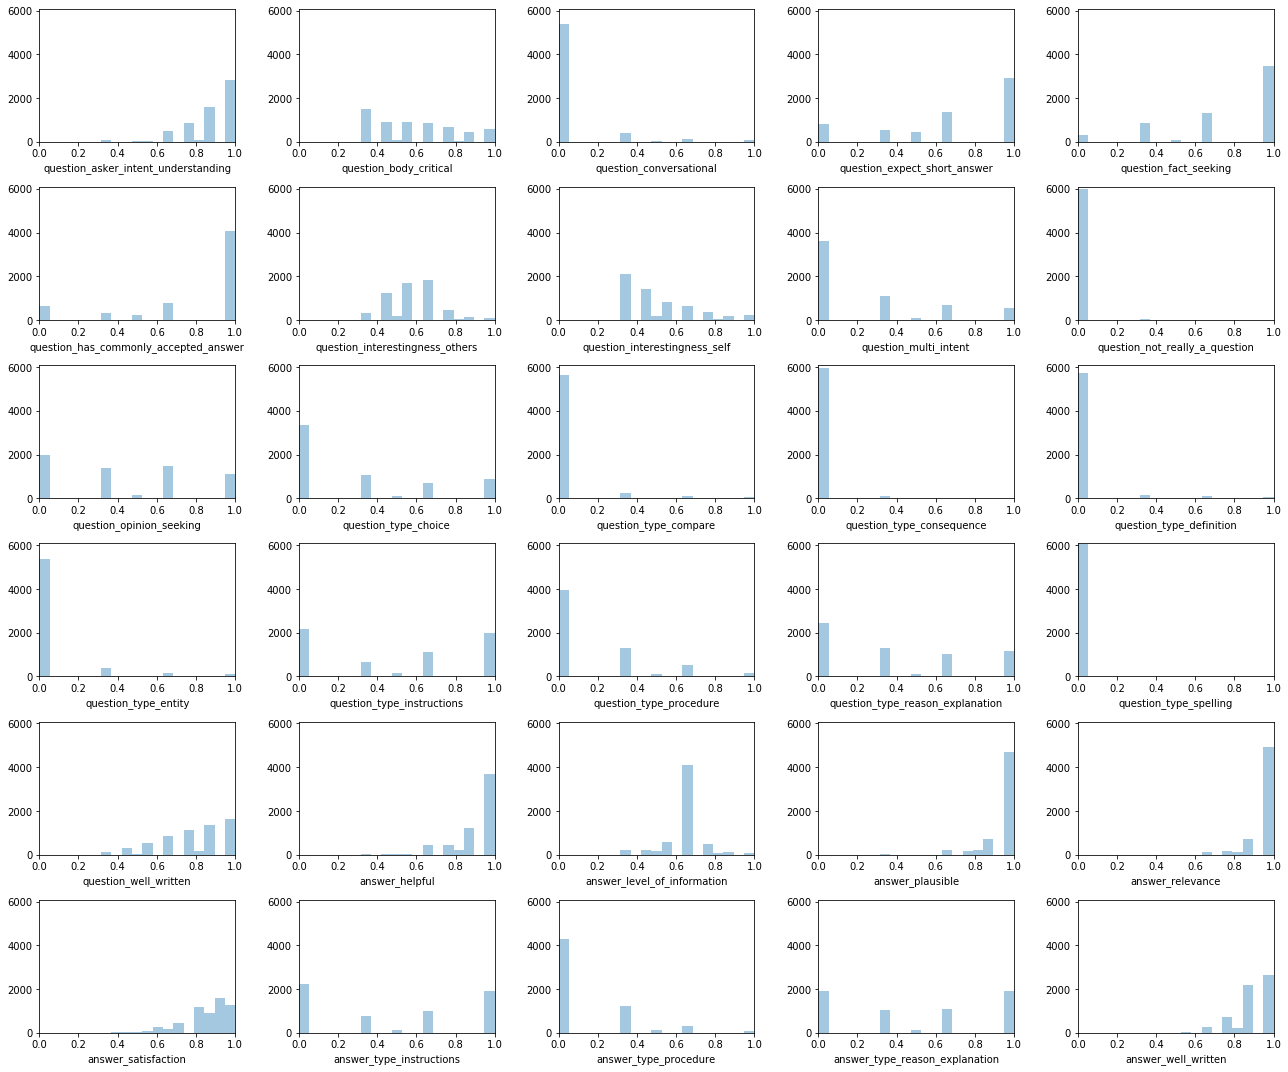

In [12]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(target_cols):
    ax = axes[i]
    sns.distplot(train[col], label=col, kde=False, bins=bins, ax=ax)
    # ax.set_title(col)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])
plt.tight_layout()
plt.show()
plt.close()

It seems some of the labels are quite imbalanced. For example "question_not_really_a_question" is almost always 0, which means most of the question in the data is not a noisy data but an "actual question".

In [13]:
train.isna().sum()

qa_id                                    0
question_title                           0
question_body                            0
question_user_name                       0
question_user_page                       0
answer                                   0
answer_user_name                         0
answer_user_page                         0
url                                      0
category                                 0
host                                     0
question_asker_intent_understanding      0
question_body_critical                   0
question_conversational                  0
question_expect_short_answer             0
question_fact_seeking                    0
question_has_commonly_accepted_answer    0
question_interestingness_others          0
question_interestingness_self            0
question_multi_intent                    0
question_not_really_a_question           0
question_opinion_seeking                 0
question_type_choice                     0
question_ty

In [14]:
test.isna().sum()

qa_id                 0
question_title        0
question_body         0
question_user_name    0
question_user_page    0
answer                0
answer_user_name      0
answer_user_page      0
url                   0
category              0
host                  0
dtype: int64

In [15]:
train_category = train['category'].value_counts()
test_category = test['category'].value_counts()

Train/Test category distribution


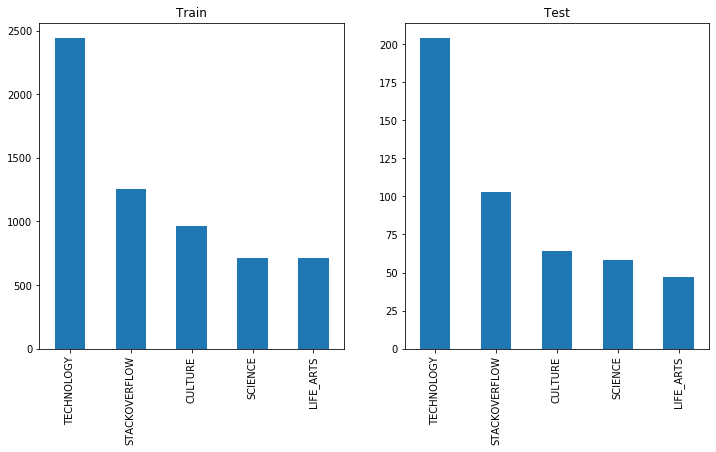

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
train_category.plot(kind='bar', ax=axes[0])
axes[0].set_title('Train')
test_category.plot(kind='bar', ax=axes[1])
axes[1].set_title('Test')
print('Train/Test category distribution')

In [22]:
from wordcloud import WordCloud

def plot_wordcloud(text, ax, title=None):
    wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
    ax.imshow(wordcloud)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

Training data Word Cloud


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



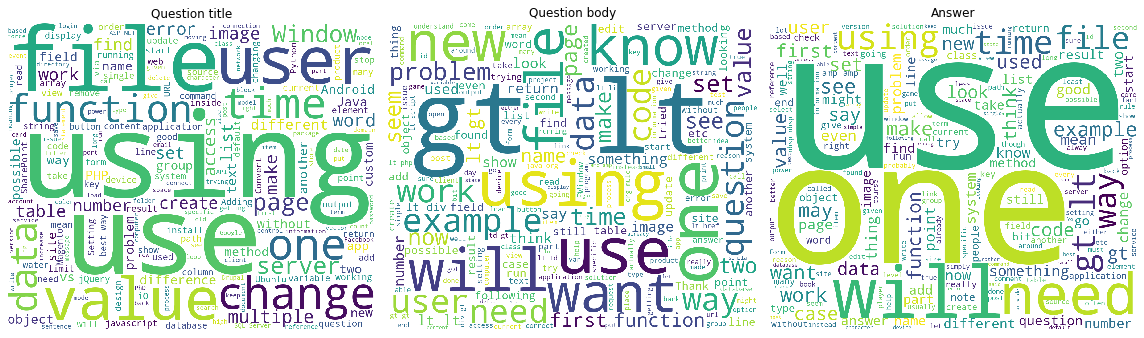

In [23]:
print('Training data Word Cloud')

fig, axes = plt.subplots(1, 3, figsize=(16, 18))

text_cat = ' '.join(train['question_title'].values)
plot_wordcloud(text_cat, axes[0], 'Question title')

text_cat = ' '.join(train['question_body'].values)
plot_wordcloud(text_cat, axes[1], 'Question body')

text_cat = ' '.join(train['answer'].values)
plot_wordcloud(text_cat, axes[2], 'Answer')

plt.tight_layout()
fig.show()

Test data Word Cloud


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



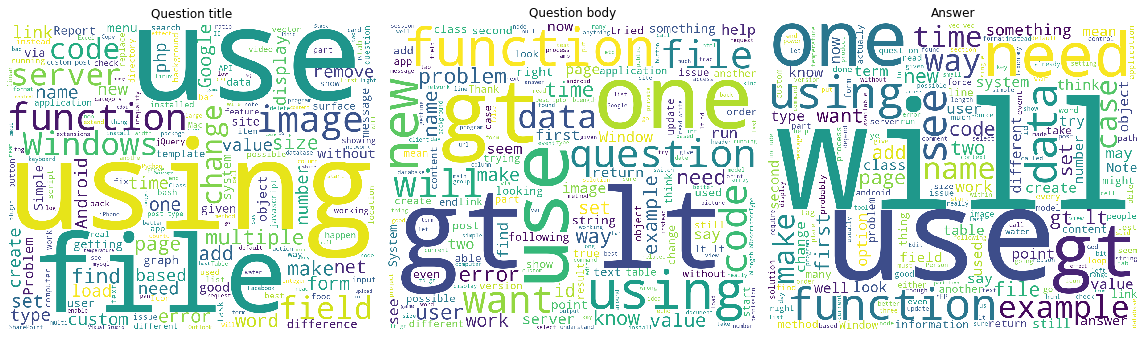

In [24]:
print('Test data Word Cloud')

fig, axes = plt.subplots(1, 3, figsize=(16, 18))

text_cat = ' '.join(test['question_title'].values)
plot_wordcloud(text_cat, axes[0], 'Question title')

text_cat = ' '.join(test['question_body'].values)
plot_wordcloud(text_cat, axes[1], 'Question body')

text_cat = ' '.join(test['answer'].values)
plot_wordcloud(text_cat, axes[2], 'Answer')

plt.tight_layout()
fig.show()

It seems common word usage distribution is similar between train & test dataset!

## Correlation in target labels

I could find following 3 pairs are correlated
- "question_type_instructions" & "answer_type_instructions"
- "question_type_procedure" & "answer_type_procedure"
- "question_type_reason_explanation" & "answer_type_reason_explanation"
This is reasonable that same evaluation on both question & answer are correlated.

On the other hand, Anticorrelation pattern can be found on following pairs:
- "question_fact_seeking" & "question_opinion_seeking"
- "answer_type_instruction" & "answer_type_reason_explanation"

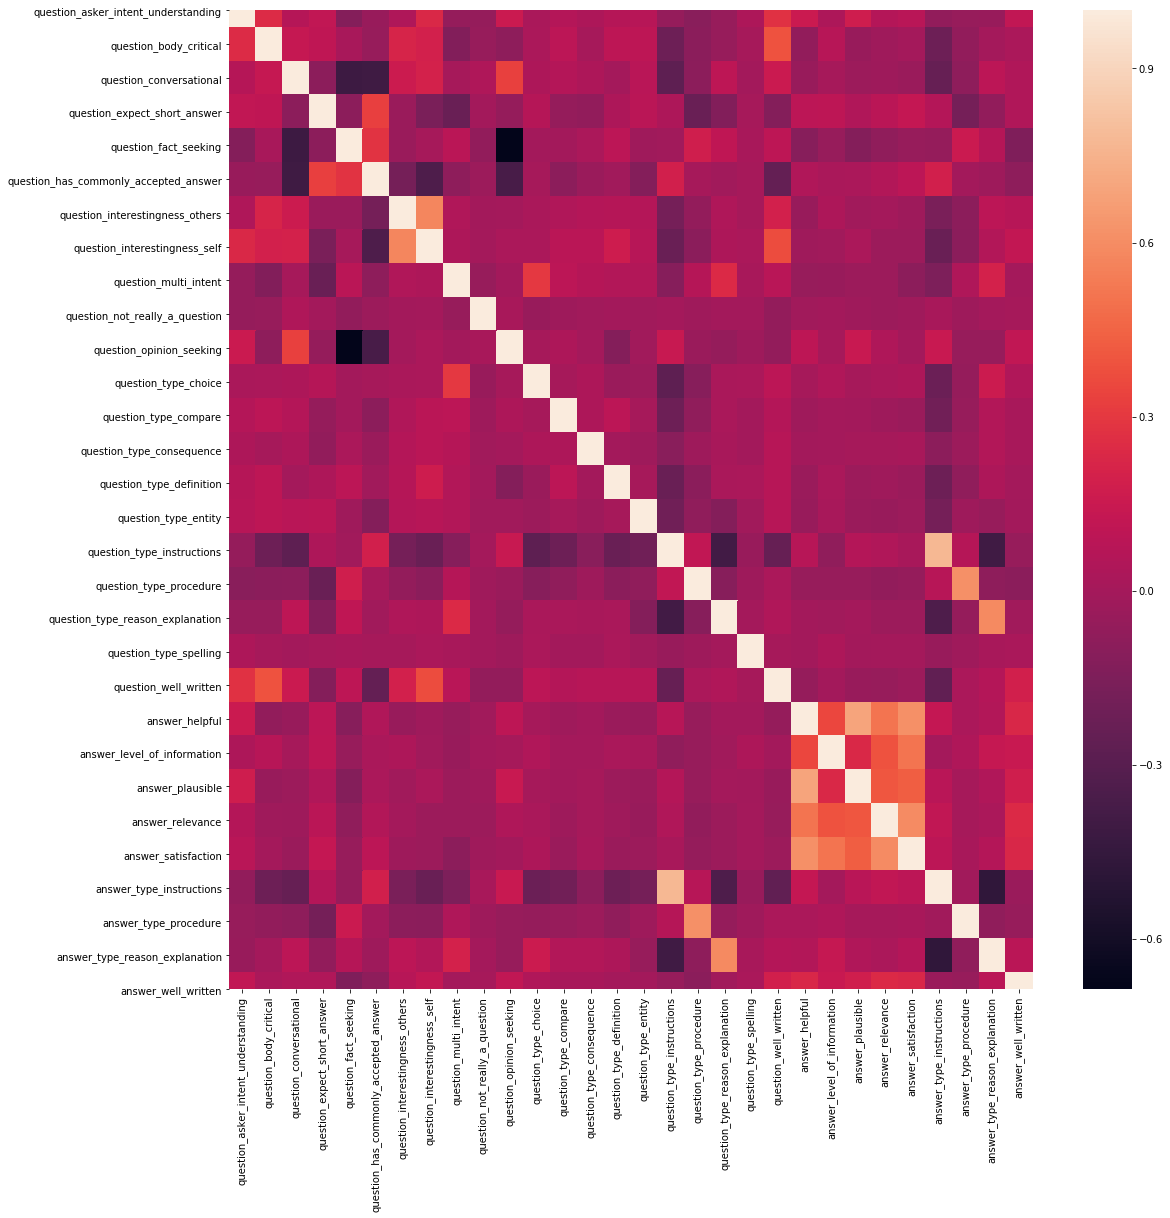

In [25]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train[target_cols].corr(), ax=ax)

In [26]:
train_question_user = train['question_user_name'].unique()
test_question_user = test['question_user_name'].unique()

print('Number of unique question user in train: ', len(train_question_user))
print('Number of unique question user in test : ', len(test_question_user))
print('Number of unique question user in both train & test : ', len(set(train_question_user) & set(test_question_user)))

Number of unique question user in train:  3215
Number of unique question user in test :  467
Number of unique question user in both train & test :  37


In [28]:
train_answer_user = train['answer_user_name'].unique()
test_answer_user = test['answer_user_name'].unique()

print('Number of unique answer user in train: ', len(train_answer_user))
print('Number of unique answer user in test : ', len(test_answer_user))
print('Number of unique answer user in both train & test : ', len(set(train_answer_user) & set(test_answer_user)))

Number of unique answer user in train:  4114
Number of unique answer user in test :  363
Number of unique answer user in both train & test :  29


In [29]:
print('Number of unique user in both question & anser in train  : ', len(set(train_answer_user) & set(train_question_user)))
print('Number of unique user in both question & anser in train  : ', len(set(test_answer_user) & set(test_question_user)))

Number of unique user in both question & anser in train  :  405
Number of unique user in both question & anser in train  :  27


In [30]:
def char_count(s):
    return len(s)

def word_count(s):
    return s.count(' ')

In [31]:
train['question_title_n_chars'] = train['question_title'].apply(char_count)
train['question_title_n_words'] = train['question_title'].apply(word_count)
train['question_body_n_chars'] = train['question_body'].apply(char_count)
train['question_body_n_words'] = train['question_body'].apply(word_count)
train['answer_n_chars'] = train['answer'].apply(char_count)
train['answer_n_words'] = train['answer'].apply(word_count)

test['question_title_n_chars'] = test['question_title'].apply(char_count)
test['question_title_n_words'] = test['question_title'].apply(word_count)
test['question_body_n_chars'] = test['question_body'].apply(char_count)
test['question_body_n_words'] = test['question_body'].apply(word_count)
test['answer_n_chars'] = test['answer'].apply(char_count)
test['answer_n_words'] = test['answer'].apply(word_count)

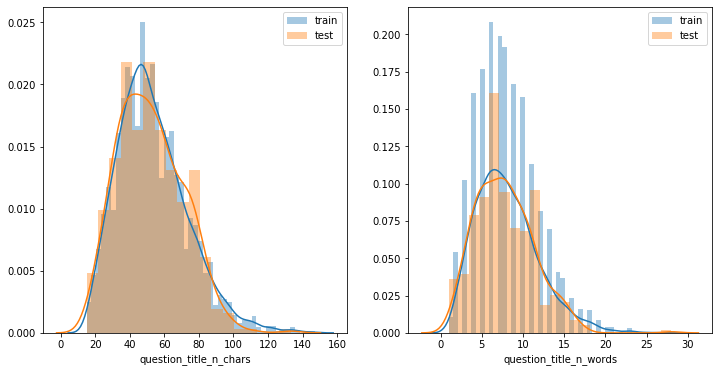

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(train['question_title_n_chars'], label='train', ax=axes[0])
sns.distplot(test['question_title_n_chars'], label='test', ax=axes[0])
axes[0].legend()
sns.distplot(train['question_title_n_words'], label='train', ax=axes[1])
sns.distplot(test['question_title_n_words'], label='test', ax=axes[1])
axes[1].legend()

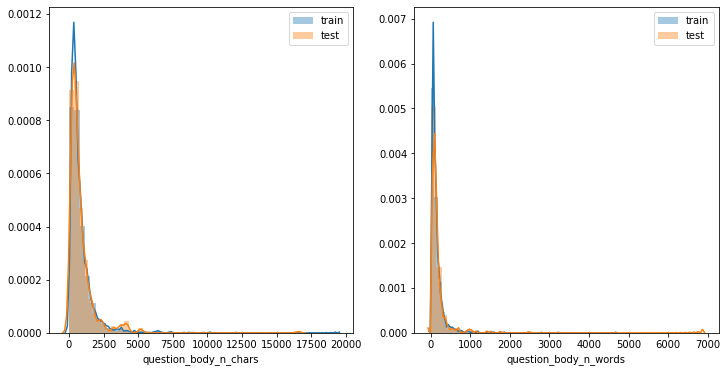

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(train['question_body_n_chars'], label='train', ax=axes[0])
sns.distplot(test['question_body_n_chars'], label='test', ax=axes[0])
axes[0].legend()
sns.distplot(train['question_body_n_words'], label='train', ax=axes[1])
sns.distplot(test['question_body_n_words'], label='test', ax=axes[1])
axes[1].legend()

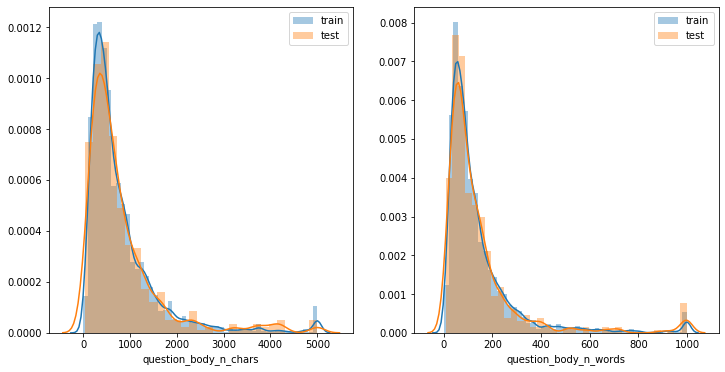

In [34]:
train['question_body_n_chars'].clip(0, 5000, inplace=True)
test['question_body_n_chars'].clip(0, 5000, inplace=True)
train['question_body_n_words'].clip(0, 1000, inplace=True)
test['question_body_n_words'].clip(0, 1000, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(train['question_body_n_chars'], label='train', ax=axes[0])
sns.distplot(test['question_body_n_chars'], label='test', ax=axes[0])
axes[0].legend()
sns.distplot(train['question_body_n_words'], label='train', ax=axes[1])
sns.distplot(test['question_body_n_words'], label='test', ax=axes[1])
axes[1].legend()

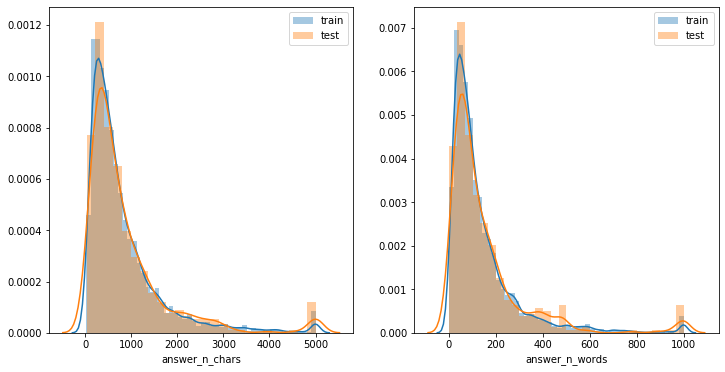

In [35]:
train['answer_n_chars'].clip(0, 5000, inplace=True)
test['answer_n_chars'].clip(0, 5000, inplace=True)
train['answer_n_words'].clip(0, 1000, inplace=True)
test['answer_n_words'].clip(0, 1000, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(train['answer_n_chars'], label='train', ax=axes[0])
sns.distplot(test['answer_n_chars'], label='test', ax=axes[0])
axes[0].legend()
sns.distplot(train['answer_n_words'], label='train', ax=axes[1])
sns.distplot(test['answer_n_words'], label='test', ax=axes[1])
axes[1].legend()

In [36]:
from scipy.spatial.distance import cdist

def calc_corr(df, x_cols, y_cols):
    arr1 = df[x_cols].T.values
    arr2 = df[y_cols].T.values
    corr_df = pd.DataFrame(1 - cdist(arr2, arr1, metric='correlation'), index=y_cols, columns=x_cols)
    return corr_df

In [37]:
number_feature_cols = ['question_title_n_chars', 'question_title_n_words', 'question_body_n_chars', 'question_body_n_words', 'answer_n_chars', 'answer_n_words']
# train[number_feature_cols].corrwith(train[target_cols], axis=0)

corr_df = calc_corr(train, target_cols, number_feature_cols)

In [38]:
corr_df

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
question_title_n_chars,0.100554,0.314277,0.034306,-0.031365,-0.035100,-0.041826,0.049084,0.060665,0.030113,-0.023643,...,0.196085,-0.000519,0.018080,0.017632,-0.009862,0.009581,-0.069191,0.004087,0.024343,0.008165
question_title_n_words,0.141260,0.370465,0.031890,-0.019632,-0.035725,-0.043174,0.077893,0.089153,0.027218,-0.034874,...,0.253358,-0.001145,0.012467,0.021827,-0.010214,0.007270,-0.059162,-0.004147,0.003671,0.012139
question_body_n_chars,-0.116880,-0.259979,0.002659,-0.105966,-0.087534,-0.038701,-0.099744,-0.105509,0.044897,0.010407,...,-0.135832,-0.003389,-0.020945,-0.002416,0.031334,-0.024069,0.153993,0.072353,0.009587,-0.026932
question_body_n_words,-0.103024,-0.242913,0.002077,-0.088583,-0.089874,-0.032784,-0.092080,-0.099233,0.034009,0.013857,...,-0.129099,0.003929,-0.015209,0.003125,0.033548,-0.018410,0.157553,0.065534,-0.003972,-0.034319
answer_n_chars,0.009147,-0.019231,0.054529,-0.120406,-0.055029,-0.056472,0.038978,0.048306,0.122885,-0.023333,...,0.040774,0.101121,0.374028,0.056591,0.081740,0.172773,-0.041012,0.069276,0.209418,0.072056
answer_n_words,0.012057,-0.018491,0.055402,-0.109595,-0.060784,-0.059186,0.041210,0.048392,0.109799,-0.022149,...,0.037305,0.092361,0.355994,0.054886,0.078011,0.160919,-0.042763,0.063125,0.196051,0.061938


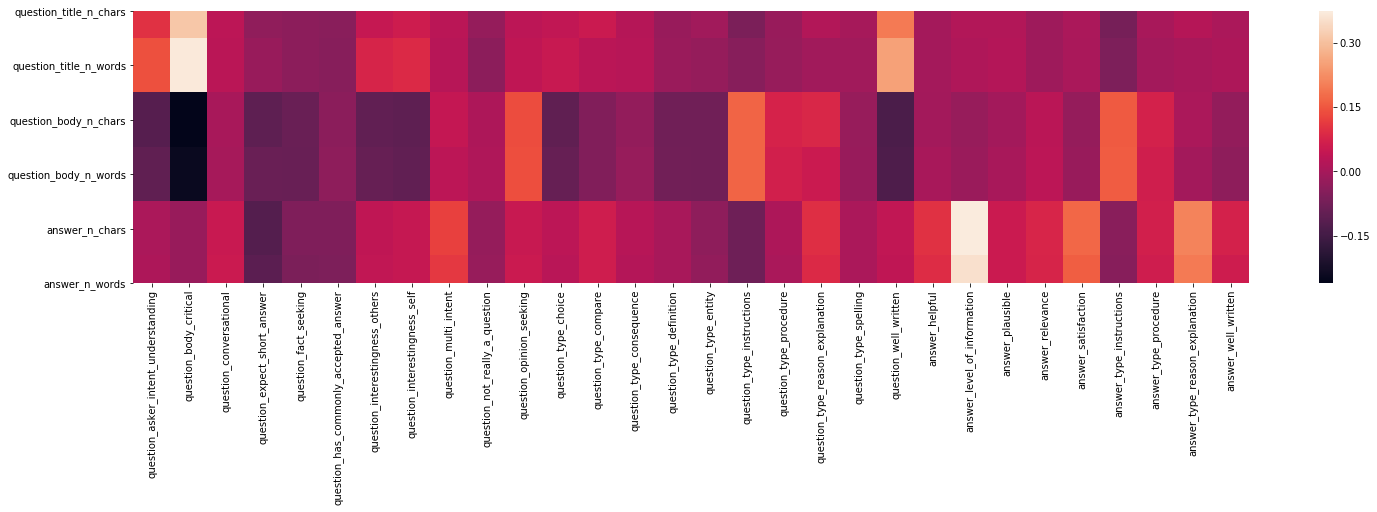

In [39]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.heatmap(corr_df, ax=ax)

In [40]:
num_question = train['question_user_name'].value_counts()
num_answer = train['answer_user_name'].value_counts()

train['num_answer_user'] = train['answer_user_name'].map(num_answer)
train['num_question_user'] = train['question_user_name'].map(num_question)
test['num_answer_user'] = test['answer_user_name'].map(num_answer)
test['num_question_user'] = test['question_user_name'].map(num_question)

In [41]:
number_feature_cols = ['num_answer_user', 'num_question_user']
# train[number_feature_cols].corrwith(train[target_cols], axis=0)

corr_df = calc_corr(train, target_cols, number_feature_cols)

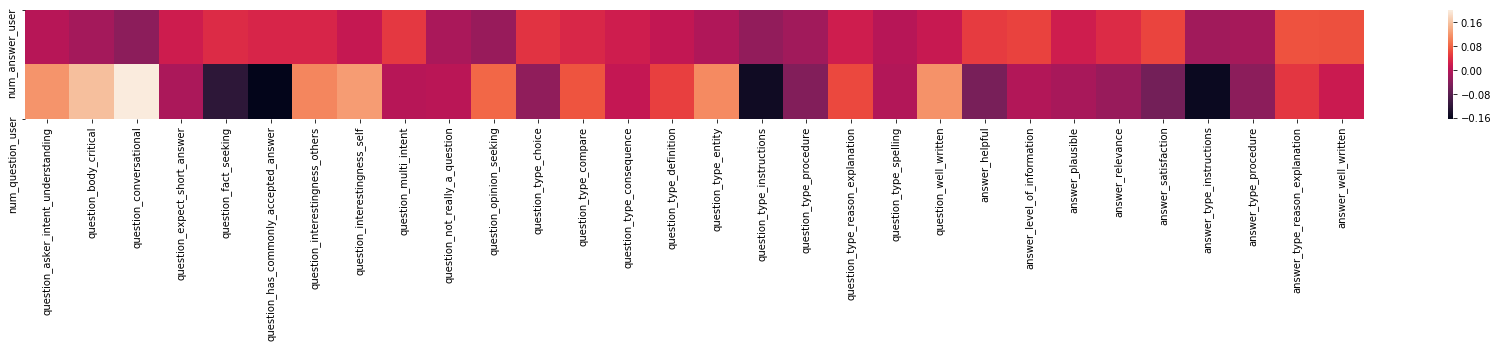

In [42]:
fig, ax = plt.subplots(figsize=(30, 2))
sns.heatmap(corr_df, ax=ax)